# 载入包

In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from dmd_api import *   #dmd_api 函数
import nidaqmx
import time, sys
import pickle

%matplotlib inline

pi = np.pi

# 产生特定的光栅图案 def grate()
-  输入参数：
    - 条纹和y轴夹角：theta
    - 狭缝宽度：a. 当a=1时，狭缝宽度等于周期一半
    - 周期d(pixel)。DMD中单位像素长度是10.8um
    - 相位phase。 指定初始相位。
    - 是否显示图像 show. 默认show=True.
    - 产生方法method。 有"direct"和"random"两种方法
    > 注：768是行数，1024是列数

- 输出
    - 图案矩阵grate:1024*768

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 0],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

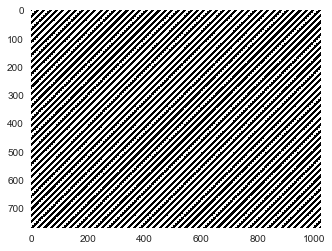

In [2]:
def randomize(phase, threshold):
    '''
    随机化方法得到光栅图案
    '''
    m = phase.shape[0]
    n = phase.shape[1]
    C = 5
    #TO DO
    #随机化方法中的参数C需要根据threshold来调以得到最佳的光栅效果,目前算法不是最佳的
    prob = 1.0 / (1 + np.exp(-1 * C * (phase - threshold)/(1 - threshold))) 
    gamble = np.random.rand(m, n)
    state = np.array((gamble < prob) * 1)
    return state

def grate(theta, a, d=32, phase=0, show=True, method="random"):
    width, height = 1024, 768
    x = np.array(range(width))
    y = np.array(range(height))
    xx, yy = np.meshgrid(x,y)
    threshold = np.cos(a * pi / 2) * np.ones(np.shape(xx))
    phase = np.cos(2 * pi / d * (np.cos(theta) * xx + np.sin(theta) * yy) + phase)
    if method == "random":
        grate = randomize(phase, threshold)
    elif method == "direct":
        grate = np.array((phase >= threshold) * 1)
    if show:
        plt.imshow(grate)
        plt.grid(False)
    return grate
    
grate(theta=pi/4, a=1,d=16, method="direct")   


# 选取部分DMD区域def select()
- 输入参数
    - 目标区域 area=((row_start, row_end, column_start, column_end),(),...),起始行列包含start和end，从0开始计数
    - 单个区域注意要这样写：area=((1,2,1,2),)这是单元组的特殊之处，不能写area=((1,2,1,2))
    - 分辨率 resolution。默认是768*1024
- 输出
    - 矩阵target，选中区域值为1，其他区域值为0.

In [3]:
def select(area, resolution=(768, 1024)):
    target = np.zeros(resolution, dtype=int)
    for item in area:
        row_start, row_end, column_start, column_end = item[0], item[1], item[2],item[3]
        target[row_start : row_end + 1, column_start: column_end + 1] = 1
    return target

select(area=((1,2,1,2),(5,6,5,6)))
select(area=((1,2,1,2), ))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# 产生各种特殊图案
## 全白white()
## 全黑black()
## 棋盘checkboard(size)
- ...


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

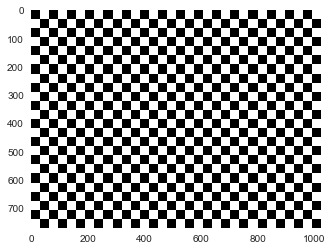

In [4]:
def white(resolution=(768, 1024), show=True):
    '''
    全白图案
    '''
    pattern = np.ones(resolution, dtype = int)
    if show:
        plt.grid(False)
        plt.imshow(pattern)
    return pattern

def black(resolution=(768, 1024), show=True):
    '''
    全黑图案
    '''
    pattern = np.zeros(resolution, dtype = int)
    if show:
        plt.grid(False)
        plt.imshow(pattern)
    return pattern

def checkboard(size=32, resolution=(768, 1024), show=True):
    '''
    输入：
    size：每个格子包含像素
    resolution：分辨率，默认768*1024
    show：是否显示图案，默认显示
    
    返回：
    图案矩阵
    '''
    pattern = np.zeros(resolution)
    pattern = np.array([1 if (int(x/size)+int(y/size))%2==0 else 0 for x in range(resolution[0])
              for y in range(resolution[1])]).reshape(resolution)
    
    if show==True:
        plt.grid(False)
        plt.imshow(pattern)
    return pattern

##   Demo 
checkboard(32)
#white()
#black()

# 保存图像 def save_pattern(pattern, filename, mode, show)
- 输入
    - pattern: 图像矩阵
    - filename: 图像名称，默认保存在img文件夹中
    - mode: 保存格式，有灰度图"grey"和二值图"binary"可选
    - show: 是否显示图案
- 输出
    - 显示图像

In [12]:
def save_pattern(pattern, filename, mode="I", show=True):
    from PIL import Image
    im = Image.fromarray(255 * pattern, mode=mode).convert('RGB')
    im.save("C:/DMD_img/" + filename)
    if show:
        im = Image.open("C:/DMD_img/" + filename)
        im.show()
    
# Demo
pattern = grate(theta=pi/4, a=1, d=8,phase=0, show=False)
save_pattern(pattern, "grate8.jpg", show=False)

# 获取PMT计数 getCounts(t)
- 输入
    - t(s): PMT积分时间。370ms 约采集1000个点
- 输出
    - counts： 计数


In [6]:
def getCounts(t=0.1):
    '''
    get counts in time duration t
    '''
    DAQ_counter = nidaqmx.Task()
    DAQ_counter.ci_channels.add_ci_count_edges_chan(b"Dev1/ctr2")
    N = int(1000.0 * t / 0.37)
    data = DAQ_counter.read(N)
    counts = data[-1] - data[0]
    return counts

In [7]:
getCounts()

152L

# 扫描相位和幅度 scan_patch()
- 输入
    - total_area: 光斑照射在DMD上总的像素区域 e.g total_area = (200, 500, 350, 650)
    - patch_size: patch的尺寸。 e.g patch_size = {"patch_row":50, "patch_col": 50}
- 输出
    - data: 包含sample_patch的行、列、附加相位、对应PMT计数


In [10]:
from pprint import pprint
def scan_patch(total_area, patch_size):
    patch_row, patch_col = patch_size["patch_row"], patch_size["patch_col"]
    #标准化的区域，第一个像素坐标是(0, 0)
    normal_area = (0, total_area[1]-total_area[0], 0, total_area[3]-total_area[2]) 
    # patch_size必须要被整除
    if normal_area[1] % patch_size["patch_row"]!=0:
        print "patch_row必须要被整除,请重新选定patch_row大小"
        return 
    if normal_area[3] % patch_size["patch_col"]!=0:
        print "patch_row必须要被整除,请重新选定patch_row大小"
        return
    
    rblock = int(normal_area[1] / patch_row)
    cblock = int(normal_area[3] / patch_col)
    ref_row = int(rblock / 2) 
    ref_col = int(cblock / 2)
    # 以中心区域作为参考patch
    ref_patch = (total_area[0] + ref_row * patch_row, total_area[0] + (ref_row + 1) * patch_row,
                 total_area[2] + ref_col * patch_col, total_area[2] + (ref_col + 1) * patch_col)
    ref_pattern = grate(theta=pi/4, a=1, d=8,phase=0, show=False) * select((ref_patch,))
    
    extra_phase = [0, 2 * pi/3, 4 * pi/3]
    count = np.zeros((rblock, cblock, len(extra_phase)))
    j = ""
    for r in range(0,rblock):
        for c in range(0,cblock):
            if c==ref_col and r == ref_row:
                continue
            
            sam_patch = (total_area[0] + r * patch_row, total_area[0] + (r + 1) * patch_row,
                         total_area[2] + c * patch_col, total_area[2] + (c + 1) * patch_col)
            # show processbar
            j += '#'
            process = int((r * 15 + c + 1)/225.0 * 100)
            sys.stdout.write("Process: "+'% '+ str(process)+"r: "+str(r)+"c: "+str(c)+j+'->'+"\r")
            sys.stdout.flush() # windows下有没有都一样，linux下会实时刷新控制台输出
            
            i = 0
            for phase in extra_phase:
                sam_pattern = grate(theta=pi/4, a=1, d=8, phase=phase, show=False) * select((sam_patch,))
                pattern = ref_pattern + sam_pattern
                '''
                下面这行代码测试时注释，运行时不要注释
                '''
                img_name = "pattern_row{0}_col{1}.jpg".format(r, c)
                save_pattern(pattern, img_name, show=False)
                
                if Demo(img_name)!= 0:
                    print "没有正常加载图像"
                    return  
                
                count[r][c][i] = float(getCounts())
                i += 1 
                
    return count

patch_size = {"patch_row":20, "patch_col": 20}
total_area = (200, 500, 350, 650)
count = scan_patch(total_area=total_area, patch_size=patch_size)  

In [11]:
filename = "./counts/" + "count-" + str(patch_size["patch_row"]) + str(patch_size["patch_row"]) + \
            time.strftime("%Y-%m-%d-%H-%M", time.localtime()) + ".pkl"
with open(filename, "wb") as f:
    pickle.dump(count, f)

#print count

# 计算相位和幅度 caculate_phase_amp(data)
- 输入
    - data: 格式如scan_patch的输出
- 输出
    - amplitude_mat
    - phase_mat

In [12]:
def calculate_phase_amp(data):
    import cmath
    row, col, _ = data.shape
    amplitude_mat = np.zeros((row, col))
    phase_mat = np.zeros((row, col))
    for r in range(row):
        for c in range(col):
            [m1, m2, m3] = data[r][c][:]
            p = complex(-1.0/3 * (m2 + m3 - 2 * m1), 1.0/np.sqrt(3) *(m2 - m3))
            amplitude_mat[r][c], phase_mat[r][c] = cmath.polar(p)
    return amplitude_mat, phase_mat
amplitude_mat, phase_mat = calculate_phase_amp(count)
#phase_mat

# 绘制相位和幅度图
## phase_diagram()
- 输入
    - result
- 无输出

## amp_diagram()
- 输入
    - result
- 无输出


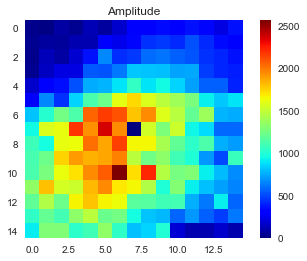

In [13]:
def amplitude_diagram(amplitude_mat, save=False, filename=0):
    row, col = amplitude_mat.shape
    X,Y = np.meshgrid(row,col)
    plt.imshow(amplitude_mat, cmap="jet")
    plt.title("Amplitude")
    plt.grid(False)
    plt.colorbar()
    if filename==0:
        filename = "amp-"+time.strftime("%Y-%m-%d-%H-%M", time.localtime())+".jpg"
    plt.savefig("./amplitude_image/"+filename)
    plt.show() #不能先show再savefig， 否则图片会变成一片空白

# example code    
amplitude_diagram(amplitude_mat, save=False, filename=0)

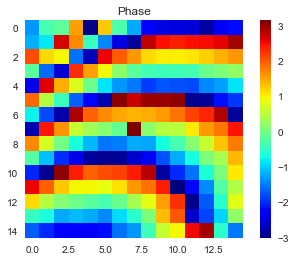

In [14]:
def phase_diagram(phase_mat, save=False, filename=0):
    row, col = phase_mat.shape
    X,Y = np.meshgrid(row,col)
    plt.imshow(phase_mat, cmap="jet")
    plt.title("Phase")
    plt.grid(False)
    plt.colorbar()
    if filename==0:
        filename = "phase-"+time.strftime("%Y-%m-%d-%H-%M", time.localtime())+".jpg"
    plt.savefig("./phase_image/"+filename)
    plt.show()

# example code
phase_diagram(phase_mat, save=False, filename=0)

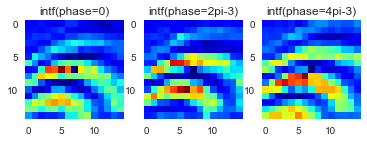

In [15]:
def interf_diagram(mat, title):
    '''
    画出三个干涉图
    '''
    row, col= mat.shape
    X,Y = np.meshgrid(row,col)
    plt.savefig("./tmp/"+title+".jpg")
    plt.imshow(mat, cmap="jet")
    plt.title(title)
    plt.grid(False)
#     plt.colorbar()

plt.subplot(1,3,1)    
mat = count[:, :, 0]
interf_diagram(mat, "intf(phase=0)" )

plt.subplot(1,3,2)    
mat = count[:, :, 1]    
interf_diagram(mat, "intf(phase=2pi-3)" )
plt.subplot(1,3,3)    
mat = count[:, :, 2]    
interf_diagram(mat, "intf(phase=4pi-3)" )

In [ ]:
import pickle
np.random.seed(100)
a = np.random.rand(3,3,2)
print a
print a[:,:,0]

# 补偿相位 phase_recover()
将测出来的相位补偿回DMD条纹，迭代几次。
- 输入
    - extra_phase: 相位矩阵
- 输出
    - phase_mat: 相位矩阵
    - amp_mat: 强度矩阵

In [29]:
def phase_recover(total_area, patch_size, origin_phase):
    
    
    patch_row, patch_col = patch_size["patch_row"], patch_size["patch_col"]
    #标准化的区域，第一个像素坐标是(0, 0)
    normal_area = (0, total_area[1]-total_area[0], 0, total_area[3]-total_area[2]) 
    # patch_size必须要被整除
    if normal_area[1] % patch_size["patch_row"]!=0:
        print "patch_row必须要被整除,请重新选定patch_row大小"
        return 
    if normal_area[3] % patch_size["patch_col"]!=0:
        print "patch_row必须要被整除,请重新选定patch_row大小"
        return
    
    rblock = int(normal_area[1] / patch_row)
    cblock = int(normal_area[3] / patch_col)
    
    assert (rblock, cblock) == origin_phase.shape
    
    ref_row = int(rblock / 2) 
    ref_col = int(cblock / 2)
    # 以中心区域作为参考patch
    ref_patch = (total_area[0] + ref_row * patch_row, total_area[0] + (ref_row + 1) * patch_row,
                 total_area[2] + ref_col * patch_col, total_area[2] + (ref_col + 1) * patch_col)
    ref_pattern = grate(theta=pi/4, a=1, d=8,phase=0, show=False) * select((ref_patch,))
    
    extra_phase = [0, 2 * pi/3, 4 * pi/3]
    count = np.zeros((rblock, cblock, len(extra_phase)))
    j = ""
    for r in range(0,rblock):
        for c in range(0,cblock):
            if c==ref_col and r == ref_row:
                continue
            
            sam_patch = (total_area[0] + r * patch_row, total_area[0] + (r + 1) * patch_row,
                         total_area[2] + c * patch_col, total_area[2] + (c + 1) * patch_col)
            # show processbar
            j += '#'
            process = int((r * 15 + c + 1)/225.0 * 100)
            sys.stdout.write("Process: "+ str(process)+"r: "+str(r)+"c: "+str(c)+'%   '+j+'->'+"\r")
            sys.stdout.flush() # windows下有没有都一样，linux下会实时刷新控制台输出
            
            i = 0
            for phase in extra_phase:
                sam_pattern = grate(theta=pi/4, a=1, d=8, phase=phase - origin_phase[r, c], show=False) * select((sam_patch,))
                pattern = ref_pattern + sam_pattern
                '''
                下面这行代码测试时注释，运行时不要注释
                '''
                img_name = "pattern_row{0}_col{1}.jpg".format(r, c)
                save_pattern(pattern, img_name, show=False)
                
                if Demo(img_name)!= 0:
                    print "没有正常加载图像"
                    return  
                
                count[r][c][i] = float(getCounts())
                i += 1 
                
    return count


In [30]:
def hello(phase_mat):
    print phase_mat[0,0]
    
phase_mat = np.zeros((15, 15))
hello(phase_mat)

0.0


In [31]:
patch_size = {"patch_row":20, "patch_col": 20}
total_area = (200, 500, 350, 650)
phase_mat = np.zeros((15, 15))
origin_phase = phase_mat
count = phase_recover(total_area=total_area, patch_size=patch_size, origin_phase=origin_phase)

DMD未连接！: 0r: 0c: 0%   #->
没有正常加载图像


In [ ]:
phase_mat, amp_mat = calculate_phase_amp(count)
amplitude_diagram(amplitude_mat, save=False, filename=0)
phase_diagram(phase_mat, save=False, filename=0)

# Experiemnt

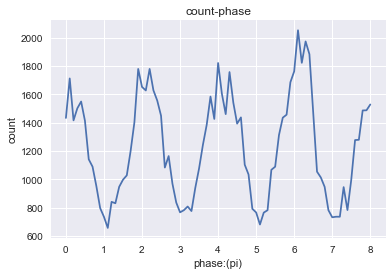

In [102]:
total_area = (200, 500, 350, 650)
patch_size = {"patch_row":20, "patch_col": 20}
patch_row, patch_col = patch_size["patch_row"], patch_size["patch_col"]
#标准化的区域，第一个像素坐标是(0, 0)
normal_area = (0, total_area[1]-total_area[0], 0, total_area[3]-total_area[2]) 
# patch_size必须要被整除
if normal_area[1] % patch_size["patch_row"]!=0:
    print "patch_row必须要被整除,请重新选定patch_row大小"
     
if normal_area[3] % patch_size["patch_col"]!=0:
    print "patch_row必须要被整除,请重新选定patch_row大小"
    
    
rblock = int(normal_area[1] / patch_row)
cblock = int(normal_area[3] / patch_col)
ref_row = int(rblock / 2) 
ref_col = int(cblock / 2)
sam_row = 4
sam_col = 4
# 以中心区域作为参考patch
ref_patch = (total_area[0] + ref_row * patch_row, total_area[0] + (ref_row + 1) * patch_row,
             total_area[2] + ref_col * patch_col, total_area[2] + (ref_col + 1) * patch_col)
ref_pattern = grate(theta=pi/4, a=1, d=8,phase=0, show=False) * select((ref_patch,))

sam_patch = (total_area[0] + sam_row * patch_row, total_area[0] + (sam_row + 1) * patch_row,
             total_area[2] + sam_col * patch_col, total_area[2] + (sam_col + 1) * patch_col)
phase_lst = np.linspace(0, 8*pi, 81)
count_lst = []
for p in phase_lst:    
    sam_pattern = grate(theta=pi/4, a=1, d=8, phase=p, show=False) * select((sam_patch,))
    pattern = ref_pattern + sam_pattern
    img_name = "tmp.jpg"
    save_pattern(pattern, img_name, show=False)
    if Demo(img_name)!= 0:
        print "没有正常加载图像"
    count_lst.append(float(getCounts()))

plt.plot(phase_lst/pi, count_lst)
plt.title("count-phase")
plt.xlabel("phase:(pi)")
plt.ylabel("count")
plt.show()


In [96]:
np.linspace(0, 4*pi, 9)

array([  0.        ,   1.57079633,   3.14159265,   4.71238898,
         6.28318531,   7.85398163,   9.42477796,  10.99557429,  12.56637061])

In [114]:
total_area = (200, 500, 350, 650)
patch_size = {"patch_row":20, "patch_col": 20}
center = ((total_area[0]+total_area[1])/2, (total_area[2]+total_area[3])/2)
patch_size = 50
ref_patch = (center[0]-patch_size/2, center[0]+patch_size/2, 
             center[1]-patch_size/2, center[1]+patch_size/2)
exp_patch = (center[0]-2*patch_size-patch_size/2, center[0]-2*patch_size+patch_size/2, 
             center[1]-2*patch_size-patch_size/2, center[1]-2*patch_size+patch_size/2)
#area2 = (475, 525, 625, 675)
pattern_ref = grate(theta=pi/4, a=1.2, d=8,phase=0, show=False) * select((ref_patch,))
pattern_iter =  grate(theta = pi/4, a=1.2, d=8, phase=pi, show=False) * select((exp_patch,))
#pattern = white() * select((total_area,))
pattern = pattern_ref + pattern_iter
#area = select(((350, 650, 500, 800),))
#pattern = grate(theta=pi/4, a=1, d=8,phase=0, show=False)
#area_mat = select((total_area,))
#area_mat = select((ref_patch,exp_patch))
#area_mat = select((ref_patch,))
#area_mat = select(((0, 768, 0, 1000),))
# area = select((area1, area2))
# area = select(((0,768,0,1024),))
#pattern = pattern * area_mat
save_pattern(pattern, "grate_8.jpg", show=True)
Demo("grate_8.jpg")

0

In [3]:
import time
import sys
 
for i in range(5):
    print i,
    #sys.stdout.flush()
    time.sleep(1)

0 1 2 3 4


In [75]:
import numpy as np
import matplotlib.pyplot as plt
pi = np.pi
def randomize(phase, threshold):
    
    m = phase.shape[0]
    n = phase.shape[1]
    C = 5
    #TO DO
    #随机化方法中的参数C需要根据threshold来调以得到最佳的光栅效果,目前算法不是最佳的
    prob = 1.0 / (1 + np.exp(-1 * C * (phase - threshold)/(1 - threshold))) 
    gamble = np.random.rand(m, n)
    state = (gamble < prob) * 1
    return state

width = 1024
height = 768
p = 32 # pixels of gating cycle
theta = pi / 4 # theta angel
siltsize = 1.0 #狭缝宽度，1对应着狭缝宽度等于周期一半。

x = np.array(range(width))
y = np.array(range(height))
xx, yy = np.meshgrid(x,y)
threshold = np.cos(siltsize * pi / 2) * np.ones(np.shape(xx)) #开启阈值，调节狭缝占空比，狭缝大小siltsize=1时，threshold=0。siltsize越小，开启阈值越小，狭缝越可能打开
phase = np.cos(2 * pi / p * (np.cos(theta) * xx + np.sin(theta) * yy))

state1 = randomize(phase, threshold)# to binary form
#plt.subplot(1,2,1)
#plt.imshow(state1)
#plt.imshow(255*state1)
# plt.xlim([0, width])
# plt.ylim([0, height])
# plt.grid(False)
# plt.axis('off')

state2 = (phase >= threshold) * 1   # to binary form
#plt.subplot(1,2,2)
#plt.imshow(state2)
#plt.xlim([0, width])
#plt.ylim([0, height])
#plt.grid()

im1 = Image.fromarray((state1)*255,mode="I").convert('RGB')
im_out = im1.transpose(Image.FLIP_TOP_BOTTOM)
im_out.show()
im_out.save("state1_0.jpg")
im1.save('./state1_0.jpg')

- DMD 像素尺寸：1024 * 768，patch尺寸：24 * 24，共有42 * 38个unit

In [83]:
import numpy as np
from PIL import Image
from pylab import *
im = Image.open('love.png')
grey_im = im.convert('L')
grey_arr = np.array(grey_im)
im1 = Image.fromarray(grey_arr,mode="L")
im2 = Image.fromarray(grey_arr, mode='1')
im1.save("love_L.png")
im2.save("love_l.png")

In [85]:
im2 = Image.fromarray(255*state2, mode='L')
im2.show()

NameError: global name 'p' is not defined

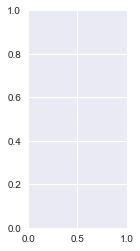

In [5]:
class Patch(object):
    '''
    定义了一个patch类，如patch面积是24*24
    patch属性：位置position，尺寸size，周期period，初始相位dphase，狭缝大小siltsize，光栅倾斜角theta
    patch方法：showpattern， 改变相位， 改变狭缝大小
    '''
    def __init__(self, position, size, period, dphase, siltsize, theta):
        self.position = position
        self.size = size
        self.period = period
        self.dphase = dphase
        self.siltsize = siltsize
        self.theta = theta
    
    def show_pattern(self):
        x = np.array(range(self.size))
        y = np.array(range(self.size))
        xx, yy = np.meshgrid(x, y)
        threshold = np.cos(self.siltsize * pi / 2) * np.ones(np.shape(xx)) 
        phase = np.cos(2 * pi / p * (np.cos(self.theta) * xx + np.sin(self.theta) * yy)+ self.dphase)
        #state = (phase >= threshold) * 1
        state = randomize(phase, threshold)
        plt.imshow(state)
        plt.xlim([0, self.size])
        plt.ylim([0, self.size])
        plt.grid()
    
    def set_phase(self, phase):
        self.dphase = self.dphase + phase
        
    def set_silt(self, ss):
        self.siltsize = ss

        
patch = Patch([1,1], 48, 4, 0, 1, pi/4) #实例化
plt.subplot(1,3,1)
patch.show_pattern() #show pattern
plt.title('original pattern')

patch.set_phase(pi) #平移pi相位
plt.subplot(1,3,2)
patch.show_pattern()
plt.title('phase shift pi')

plt.subplot(1,3,3)
patch.set_silt(0.5) #改变狭缝大小
patch.show_pattern()
plt.title('silt size are 0.5')

In [269]:
a = [1, 2]
isinstance(a, list)

True

#  Error diffusion 算法

In [14]:
from PIL import Image

def error_diffusion(pixel, size=(1,1)): 
    '''
      Diffuse on a single channel, using Floyd-Steinberg kerenl.
      @param pixel PIL PixelAccess object.
      @param size A tuple to represent the size of pixel.
      original github code: https://github.com/justmao945/lab/blob/master/halftoning/error-diffusion/ed.py
    '''
    for y in xrange(0, size[1]-1):
        for x in xrange(1, size[0]-1):
            oldpixel = pixel[x, y]
            pixel[x, y] = 255 if oldpixel > 127 else 0
            quant_error = oldpixel - pixel[x, y]
            pixel[x+1, y  ] = pixel[x+1, y  ] + 7/16.0 * quant_error
            pixel[x-1, y+1] = pixel[x-1, y+1] + 3/16.0 * quant_error
            pixel[x,   y+1] = pixel[x,   y+1] + 5/16.0 * quant_error
            pixel[x+1, y+1] = pixel[x+1, y+1] + 1/16.0 * quant_error

im = Image.open("love.png").convert('L')
im_arr = np.array(im).T
error_diffusion( im_arr, im.size )
im2 = Image.fromarray(im_arr.T, mode='L')
im.show()

In [19]:
pixel=im.load()
pixel.shape
#im.size

AttributeError: 'PixelAccess' object has no attribute 'shape'